# Quickstart

The latest release of TAPE is installable via pip, using the following command:

```
pip install lf-tape
```

For more detailed installation instructions, see the [Installation Guide](installation.html).

TAPE provides a scalable framework for analyzing astronomical time series data. Let's walk through a brief example where we calculate the Structure Function for a set of spectroscopically confirmed QSOs. First, we grab the available TAPE Stripe 82 QSO dataset:

In [ ]:
from tape import Ensemble

ens = Ensemble()  # Initialize a TAPE Ensemble
ens.from_dataset("s82_qso")

This dataset contains 9,258 QSOs, we can view the first 5 entries in the "object" table to get a sense of the available object-level information:

In [124]:
ens.head("object", 5)

,ra,dec,SDR5ID,M_i,M_i_corr,redshift,mass_BH,Lbol,u,g,r,i,z,Au,nobs_total
dbID,,,,,,,,,,,,,,,
102187,2.815377,1.249789,406,-22.891,-23.368,0.5804,8.023,45.571,20.777,20.368,19.950,19.570,19.273,0.142,95
138158,10.133773,-0.230790,1541,-22.266,-22.827,0.2419,8.332,45.131,19.090,18.857,18.485,18.085,18.033,0.117,105
187596,10.556096,0.988253,1615,-22.652,-23.392,0.3289,8.392,45.321,19.915,19.185,18.589,18.423,17.770,0.105,95
711662,15.176414,1.083781,2359,-22.703,-23.310,0.6383,0.000,0.000,20.942,20.491,20.330,19.979,19.815,0.117,100
762267,343.360626,0.507056,75223,-22.187,-23.001,0.4627,7.856,45.186,21.107,20.647,20.193,19.855,19.529,0.465,95


The Ensemble stores data in two `dask` dataframes, object-level information in the "object" table as shown above, and individual time series measurements in the "source" table. As a result, many operations on the Ensemble closely follow operations on `dask` (and by extension `pandas`) dataframes. Let's filter down our large QSO set to a smaller set with the total number of observations per object within a certain range:

In [125]:
ens.calc_nobs()  # calculates number of observations, produces "nobs_total" column
ens = ens.query("nobs_total >= 95 & nobs_total <= 105", "object")

We can now view the entirety of our remaining QSO set:

In [126]:
ens.compute("object")

,ra,dec,SDR5ID,M_i,M_i_corr,redshift,mass_BH,Lbol,u,g,r,i,z,Au,nobs_total
dbID,,,,,,,,,,,,,,,
102187,2.815377,1.249789,406,-22.891,-23.368,0.5804,8.023,45.571,20.777,20.368,19.950,19.570,19.273,0.142,95
138158,10.133773,-0.230790,1541,-22.266,-22.827,0.2419,8.332,45.131,19.090,18.857,18.485,18.085,18.033,0.117,105
187596,10.556096,0.988253,1615,-22.652,-23.392,0.3289,8.392,45.321,19.915,19.185,18.589,18.423,17.770,0.105,95
711662,15.176414,1.083781,2359,-22.703,-23.310,0.6383,0.000,0.000,20.942,20.491,20.330,19.979,19.815,0.117,100
762267,343.360626,0.507056,75223,-22.187,-23.001,0.4627,7.856,45.186,21.107,20.647,20.193,19.855,19.529,0.465,95
1128581,339.200653,1.190031,74754,-24.092,-24.483,0.5481,0.000,45.471,20.410,19.395,18.889,18.333,18.346,0.398,95
1250783,28.063360,0.648427,4283,-23.270,-24.417,0.8656,8.432,45.550,20.865,20.368,20.131,20.169,19.936,0.158,105
1254675,29.243357,0.271094,4485,-22.436,-23.097,0.3593,7.834,45.277,19.277,19.202,19.007,18.873,18.387,0.161,105
1266724,26.613321,0.350273,4077,-22.295,-22.739,0.4051,8.177,45.200,19.993,19.623,19.428,19.300,18.959,0.154,105


Finally, we can calculate the Structure Function for each of these QSOs, using the available TAPE Structure Function Module:

In [127]:
from tape.analysis import calc_sf2

result = ens.batch(
    calc_sf2, sf_method="macleod_2012"
)  # The batch function applies the provided function to all individual lightcurves within the Ensemble
result.compute()

/astro/users/atzanida/Desktop/research/tape/src/tape/ensemble.py:2175: UserWarning: Divisions are not known, syncing using a non-lazy method.
  warnings.warn("Divisions are not known, syncing using a non-lazy method.")


Using generated label, result_2, for a batch result.


lc_id band           dt          sf2  1_sigma
dbID                                                       
4938823 0   4938823    g   195.141837     0.069303      0.0
        1   4938823    g   677.738157     0.070085      0.0
        2   4938823    g  1352.291003     0.158352      0.0
        3   4938823    i   195.141837     0.016914      0.0
        4   4938823    i   677.738157     0.013114      0.0
...             ...  ...          ...          ...      ...
3777871 10  3777871    u   287.080530     0.083825      0.0
        11  3777871    u   734.527928  7945.318306      0.0
        12  3777871    z    26.076964     0.020663      0.0
        13  3777871    z   287.080530     0.031083      0.0
        14  3777871    z   734.527928     0.027969      0.0

[250 rows x 5 columns]

The result is a table of delta times (dts) and structure function (sf2) for each unique lightcurve (labeled by lc_id). We can now visualize our delta times versus the computed structure function for each unique object.

(0.0, 2000.0)

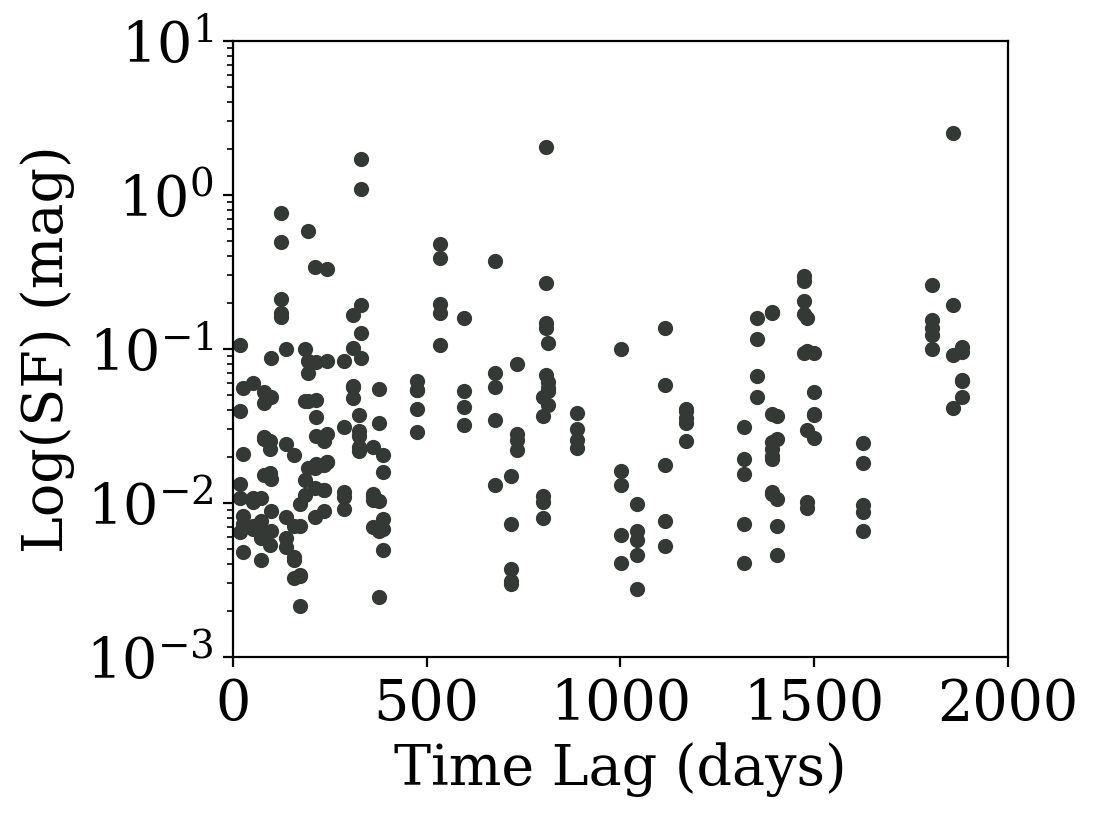

In [129]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
plt.scatter(result["dt"], result["sf2"], s=20, alpha=1, color="#353935")
plt.yscale("log")
plt.ylabel("Log(SF) (mag)")
plt.xlabel("Time Lag (days)")
plt.ylim(1e-3, 1e1)
plt.xlim(0, 2e3)

Finally, suppose we want to select the ID with the maximum sf2 value from the computed feature. Using the available `ens.to_timeseries()` that creates a TimeSeries object, we can access the light curve for the target ID.

In [130]:
max_id = result.compute()["sf2"].idxmax()[0]
lc = ens.to_timeseries(max_id)
lc

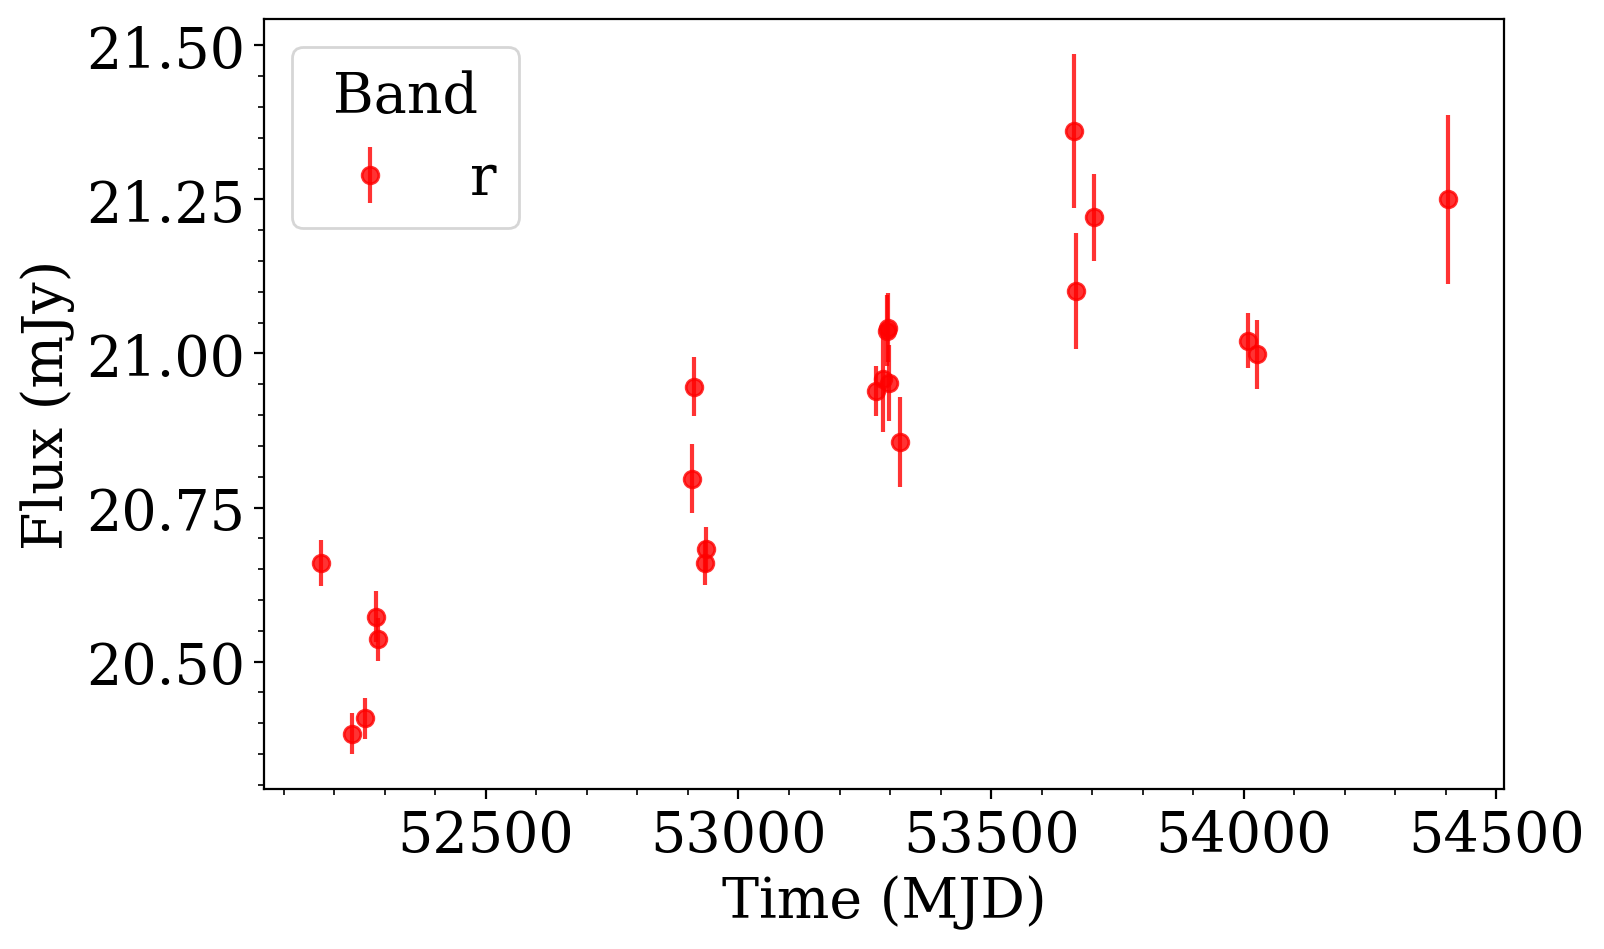

In [131]:
filter_r = lc.band == "r"  # select filter

plt.figure(figsize=(8, 5))
plt.errorbar(
    lc.time[filter_r], lc.flux[filter_r], lc.flux_err[filter_r], fmt="o", color="red", alpha=0.8, label="r"
)
plt.minorticks_on()
plt.ylabel("Flux (mJy)")
plt.xlabel("Time (MJD)")
plt.legend(title="Band", loc="upper left")